Jin Yang created a hot dog classifier to get funding from Raviga. How hard could it be ?

Installing dependancies

In [1]:
# import dependancies
!pip install -Uqq fastbook
!pip install duckduckgo_search==2.9.1
import fastbook
fastbook.setup_book()
from fastbook import *


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
Mounted at /content/gdrive


Fetching hot dog and dog images from the DuckDuckGo

In [2]:

searches = ['hot dog', 'dog']
path = Path('hot_dog_or_not')
from time import sleep

for x in searches :
    dest = (path/x)
    dest.mkdir(exist_ok= True, parents =True)
    urls = search_images_ddg(f'{x} photo', max_images =10)
    download_images(dest,urls=urls)
    sleep(10)

    # long hot dog/ not hot dog
    urls = search_images_ddg(f'long {x} photo ',  max_images =10)
    download_images(dest,urls=urls)

    # small hot dog/ not hot dog
    urls = search_images_ddg(f'small {x} photo',  max_images =10)
    download_images(dest,urls=urls)

    # resize images
    resize_images(path/x,max_size=400, dest=path/x)

Removing the failed image links

In [3]:
# check for failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Creating a datablock for our hot dog/ not hot dog images

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


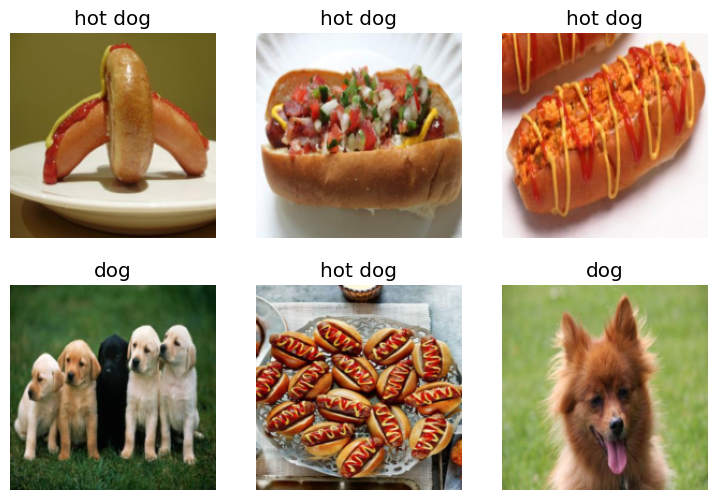

In [4]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192,method='squish')]
).dataloaders(path,bs=32)

dls.show_batch(max_n=6)

Time for Resnet 34 to be in action

In [5]:
learn = vision_learner(dls,resnet34,metrics = error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 142MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.202013,0.886092,0.454545,00:17


epoch,train_loss,valid_loss,error_rate,time
0,0.854092,0.589945,0.363636,00:17
1,0.668881,0.474217,0.090909,00:14
2,0.564148,0.602951,0.090909,00:12


Tests are important for learning. Let's conduct one on our trained model

In [11]:
# save image to destination
test_url = search_images_ddg('hot dog photos', max_images =1)
from fastdownload import download_url
dest_test = 'hotdog.jpg'
download_url(test_url[0],dest,show_progress=False)

# predict
is_hot_dog,_,probs = learn.predict(dest_test)
print(f'This is a : {is_hot_dog}')
print(f"Probability it's a hot dog: {probs[1].item():.6f}")


This is a : hot dog
Probability it's a hot dog: 0.999932


Lets just check our hot dog image to be sure

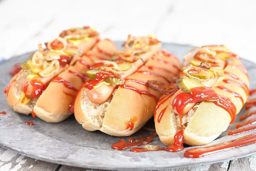

In [10]:
from fastai.vision.all import *
im = Image.open(dest_test)
im.to_thumb(256,256)